<a href="https://colab.research.google.com/github/AshvinVignesh/DL_CW_2/blob/main/Distilbert_TF_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.layers import Dense
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import  DistilBertConfig
import pickle


In [ ]:
import pandas as pd
df = pd.read_csv('yelp_reviews_2500.csv')
df=df.loc[:, ['stars', 'text']]
df

,stars,text
0,3.0,Cool structure to go see if visiting Nashville...
1,3.0,We planned a trip to Philly around my husbands...
2,3.0,Always good service. Room was clean except the...
3,3.0,"This place has been here for years and years, ..."
4,3.0,This is a very large location (with a ton of T...
...,...,...
2495,2.0,10/2/16 Update. I have been back twice since ...
2496,2.0,We were excited about Certa Pro completing our...
2497,2.0,Driven by numerous times and finally came in. ...
2498,2.0,Let me say that the service was excellent. The...


In [ ]:
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4

In [ ]:
df['stars'] = df.stars.apply(map_sentiment_scores)


In [ ]:
df.head(5)

,stars,text
0,2,Cool structure to go see if visiting Nashville...
1,2,We planned a trip to Philly around my husbands...
2,2,Always good service. Room was clean except the...
3,2,"This place has been here for years and years, ..."
4,2,This is a very large location (with a ton of T...


In [ ]:
Text = df['text'].to_list()
labels = df['stars'].to_list()


In [ ]:
print(type(Text))  # Should be <class 'numpy.ndarray'> or <class 'list'>
print(type(Text[0]))

<class 'list'>
<class 'str'>


In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 500

review = Text[0]

tokernizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tokernizer(review, max_length=MAX_LEN, truncation=True, padding=True)

print(f'review: \'{review}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

review: 'Cool structure to go see if visiting Nashville.  If it is a pretty day with nice weather, take a picnic and enjoy Centennial Park while there!'
input ids: [101, 4658, 3252, 2000, 2175, 2156, 2065, 5873, 8423, 1012, 2065, 2009, 2003, 1037, 3492, 2154, 2007, 3835, 4633, 1010, 2202, 1037, 12695, 1998, 5959, 15483, 2380, 2096, 2045, 999, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokernizer(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(Text, tokernizer, max_len=MAX_LEN)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, labels)

Try increasing the BATCH_SIZE

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 16

train_size = int(len(Text) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(Text))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
config =DistilBertConfig.from_pretrained(MODEL_NAME)

In [ ]:
config.num_labels = 5

In [ ]:
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, config = config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
input_ids_layer = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="input_ids")
attention_mask_layer = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="attention_mask")

In [ ]:
distilbert_output = distilbert_model([input_ids_layer, attention_mask_layer])[0]
dropout_layer = tf.keras.layers.Dropout(0.1)(distilbert_output)
dense_layer = tf.keras.layers.Dense(128, activation='relu')(dropout_layer)
output = tf.keras.layers.Dense(5, activation='softmax')(dense_layer)

In [ ]:
model = tf.keras.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)

In [ ]:
N_EPOCHS = 5

optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_for_sequenc  TFSequenceClassifierOutput   6695731   ['input_ids[0][0]',           
 e_classification_1 (TFDist  (loss=None, logits=(None,    7          'attention_mask[0][0]']      
 ilBertForSequenceClassific  5),                                                              

In [ ]:
history =model.fit(tfdataset_train,
                   batch_size=BATCH_SIZE,
                   epochs=N_EPOCHS)

Epoch 1/5
125/125 [==============================] - 128s 837ms/step - loss: 1.5180 - accuracy: 0.2970
Epoch 2/5
125/125 [==============================] - 113s 900ms/step - loss: 1.2885 - accuracy: 0.4230
Epoch 3/5
125/125 [==============================] - 114s 913ms/step - loss: 1.1161 - accuracy: 0.4960
Epoch 4/5
125/125 [==============================] - 115s 917ms/step - loss: 0.9464 - accuracy: 0.6030
Epoch 5/5
125/125 [==============================] - 115s 918ms/step - loss: 0.8311 - accuracy: 0.6510


In [ ]:
history

In [ ]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch

In [ ]:
history_df

,loss,accuracy,epoch
0,1.518020,0.297,0
1,1.288459,0.423,1
2,1.116112,0.496,2
3,0.946402,0.603,3
4,0.831095,0.651,4


<Axes: xlabel='epoch'>

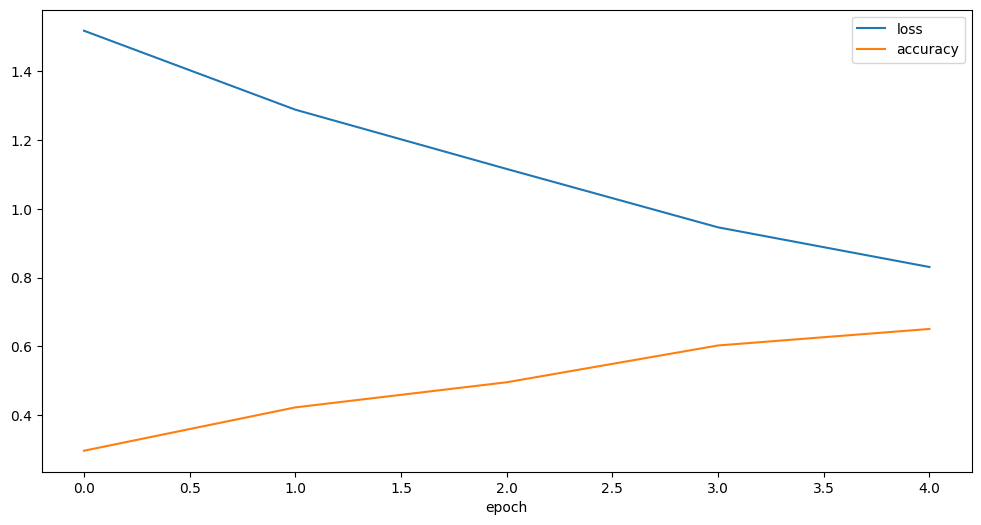

In [ ]:
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(12, 6))  # Unpack axes from the tuple

history_df.plot(x="epoch", y=["loss", "accuracy"], ax=ax0)
# history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

In [ ]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
benchmarks

32/32 [==============================] - 12s 322ms/step - loss: 0.5777 - accuracy: 0.8140


{'loss': 0.5776705741882324, 'accuracy': 0.8140000104904175}

In [ ]:
import numpy as np

test_text = """Decent poke at an okay price. We got two bowls with sushi rice: salmon and albacore, and salmon and seared cajun tuna.Good: The salmon and tuna were good, and there's a large selection of  mixins and addons -- I consistently get the crab salad, seaweed salad, and tofu skins.
Bad: The albacore was overly salty and many of the pieces were overcooked and rubbery. The sauces are good but I wish there was more added, without having to pay extra."
Overall, nothing spectacular, but Pokeman is an average option in University City"""

test_input = tokernizer(test_text, padding="max_length", truncation=True, return_tensors="tf",max_length=500)

predictions = model.predict(dict(test_input))

# # Get the probabilities for each class
# logits = predictions.logits

# # Apply softmax to get probabilities
# probabilities = tf.nn.softmax(logits, axis=-1).numpy()# Convert logits to probabilities using softmax

print(predictions)

1/1 [==============================] - 2s 2s/step
[[0.0087669  0.05558163 0.6946826  0.16299523 0.07797353]]


In [ ]:
predicted_label_index = np.argmax(predictions)
predicted_label_index

2

In [ ]:
print("Ratings :" ,float(predicted_label_index + 1 ))

Ratings : 3.0


Saving and loading the model

In [ ]:
# model.save_pretrained('./model/clf')
# with open('./model/info.pkl', 'wb') as f:
#     pickle.dump((MODEL_NAME, MAX_LEN), f)

In [ ]:
# new_model = TFDistilBertForSequenceClassification.from_pretrained('./model/clf')
# model_name, max_len = pickle.load(open('./model/info.pkl', 'rb'))

# clf = create_predictor(new_model, model_name, max_len)
# print(clf('this restaurant has horrible food'))

load model

In [ ]:
# new_model = TFDistilBertForSequenceClassification.from_pretrained('./model/clf')
# model_name, max_len = pickle.load(open('./model/info.pkl', 'rb'))

# clf = create_predictor(new_model, model_name, max_len)
# print(clf('this restaurant has horrible food'))